<a href="https://colab.research.google.com/github/jefernandezec/s2s/blob/main/S2S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fundamentals of Survey-to-Survey Imputation

**1. Creating a dataset with a model-based consumption per capita**

Set seed for reproducibility and simulate raw variables

In [59]:
set.seed(1729)
n <- 1000

age             <- sample(18:79, n, replace = TRUE)
age_sq          <- age^2
house_ownership <- rbinom(n, 1, 0.6)   # 1 = owns house
employed    <- rbinom(n, 1, 0.7)   # 1 = employed
electricity     <- rbinom(n, 1, 0.8)   # 1 = has electricity
wallsbrick <- rbinom(n, 1, 0.75)   # 1 = walls material: brick
roofmetal  <- rbinom(n, 1, 0.25)   # 1 = roof material: brick
floordirt  <- rbinom(n, 1, 0.15)   # 1 = floor material: dirt
areaurban  <- rbinom(n, 1, 0.65)   # 1 = urban
hhsize     <- sample(1:8, n, replace = TRUE)

df <- data.frame(
  age, age_sq, house_ownership, employed, electricity,
  wallsbrick,roofmetal,floordirt,areaurban,hhsize
)

Define "actual" coefficients

In [60]:
base_coeffs <- c(
  age             = 0.3,
  age_sq          = -0.002,
  house_ownership = 5,
  employed    = 10,
  electricity     = 8,
  wallsbrick     =3,
  roofmetal     = 4,
  floordirt     = -5,
  areaurban    =7
)

Simulate normal random noise and create per capita consumption

In [61]:
noise=rnorm(n,sd=3) #alternative for normal noise
#noise=rexp(n, rate = 1/10) - 10
base_coeffs = matrix(base_coeffs,ncol=1)

#df$consumption_pc=exp(B_0 + as.matrix(df)%*%base_coeffs+noise) #alternative for normal noise
df$consumption_pc=as.matrix(df[,-10])%*%base_coeffs+noise

head(df)

,age,age_sq,house_ownership,employed,electricity,wallsbrick,roofmetal,floordirt,areaurban,hhsize,consumption_pc
,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,"<dbl[,1]>"
1,36,1296,1,1,1,0,0,0,1,5,47.08274
2,75,5625,1,0,0,0,1,0,0,4,24.71662
3,59,3481,0,0,1,0,0,0,1,5,23.80194
4,62,3844,1,0,1,1,1,0,0,7,34.28391
5,78,6084,1,1,1,0,0,0,0,2,36.81708
6,60,3600,1,0,1,0,0,1,0,5,16.65397


Visualize the density plot

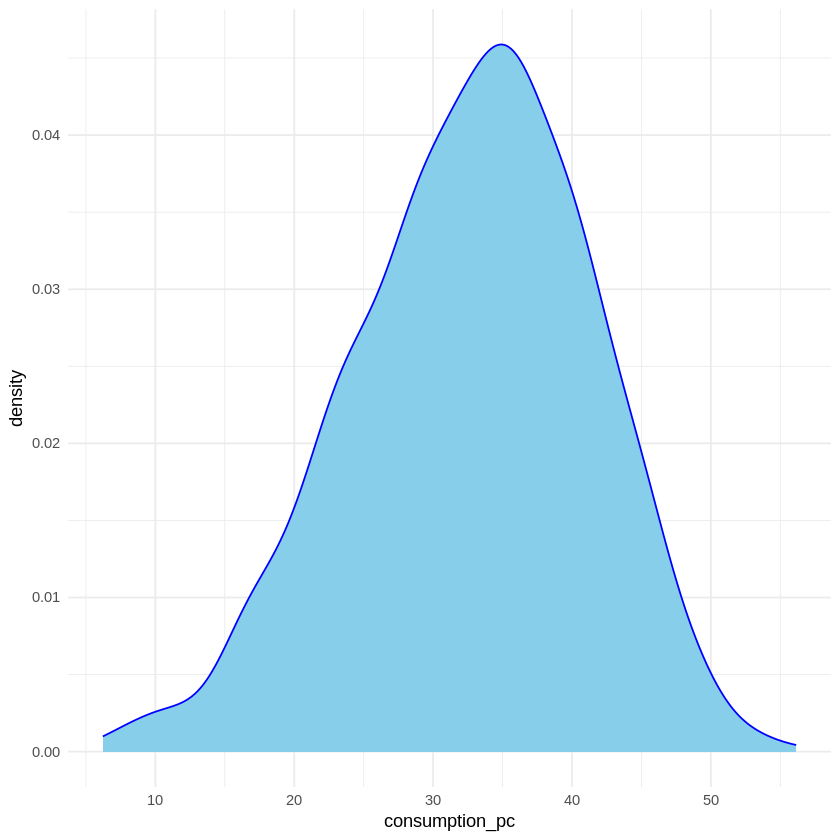

In [62]:
library(ggplot2)

ggplot(df, aes(x = consumption_pc)) +
  geom_density(fill = "skyblue", color = "blue") +
  theme_minimal()

Adjust linear model for consumption_pc

In [63]:
mod0=lm(consumption_pc ~ . , df)
summary(mod0)


Call:
lm(formula = consumption_pc ~ ., data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.5219 -2.1111 -0.0015  2.1474 10.4809 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -0.4658529  0.8659668  -0.538   0.5907    
age              0.3464329  0.0343914  10.073  < 2e-16 ***
age_sq          -0.0024484  0.0003493  -7.009 4.42e-12 ***
house_ownership  5.3012129  0.2046360  25.906  < 2e-16 ***
employed         9.7824611  0.2184844  44.774  < 2e-16 ***
electricity      8.0676693  0.2421746  33.313  < 2e-16 ***
wallsbrick       2.7564545  0.2361947  11.670  < 2e-16 ***
roofmetal        3.9077429  0.2282626  17.120  < 2e-16 ***
floordirt       -4.7647497  0.2733742 -17.429  < 2e-16 ***
areaurban        7.1307734  0.2133029  33.430  < 2e-16 ***
hhsize          -0.0999960  0.0439585  -2.275   0.0231 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.177 on 989 degrees of freedom
Multipl

Visualize residuals

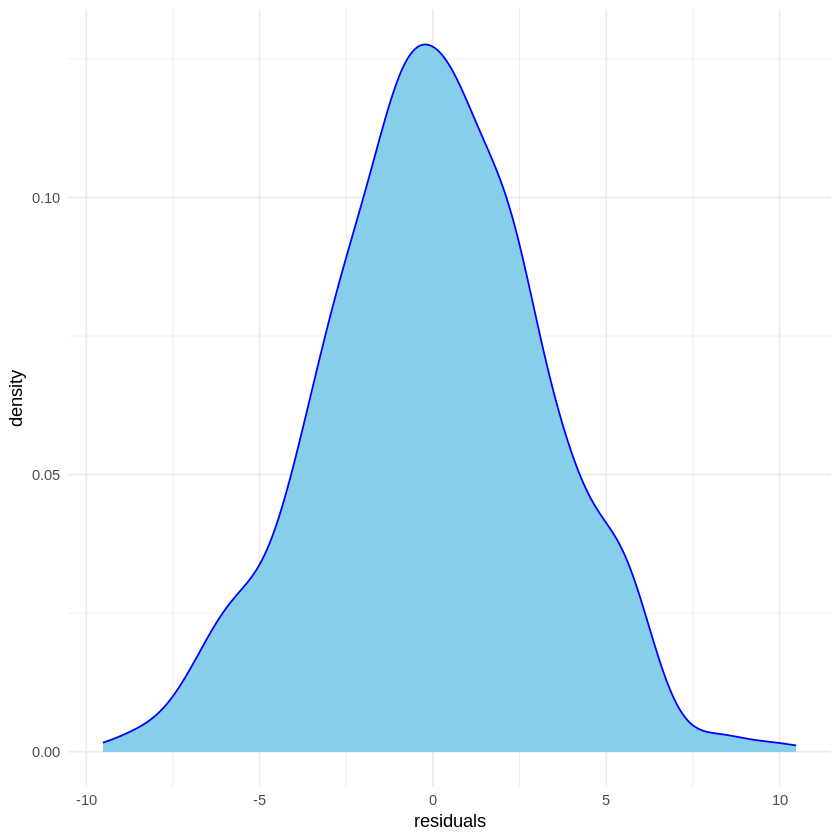

In [64]:
df$residuals = mod0$residuals

ggplot(df, aes(x = residuals)) +
  geom_density(fill = "skyblue", color = "blue") +
  theme_minimal()


How does the prediction look compared to the actual distribution?

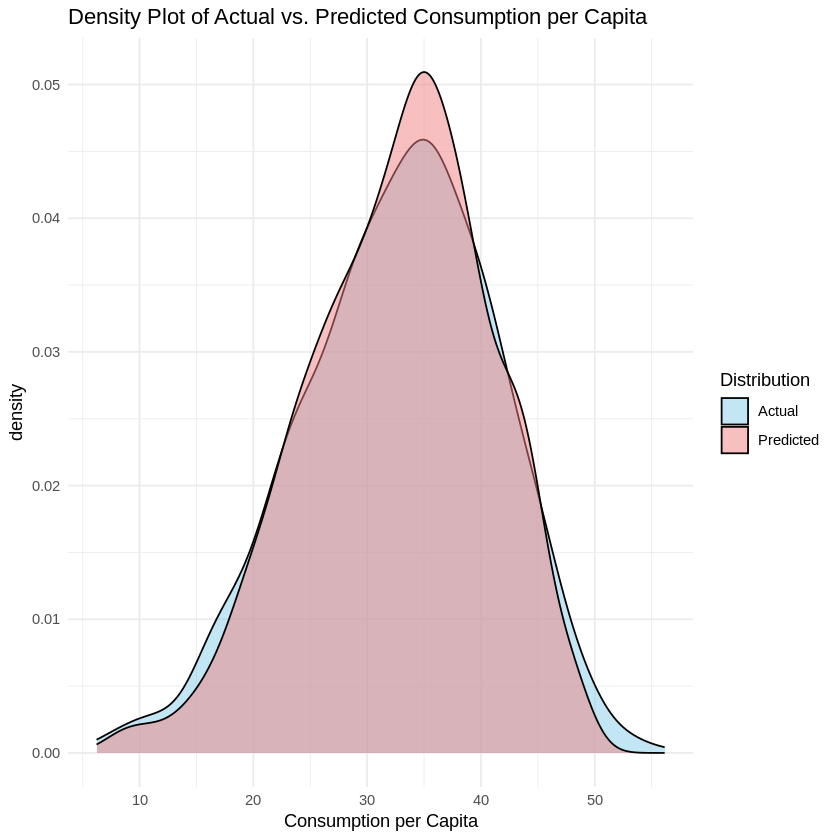

In [65]:
df$predicted <- predict(mod0)

ggplot(df, aes(x = consumption_pc)) +
  geom_density(aes(fill = "Actual"), alpha = 0.5) +
  geom_density(aes(x = predicted, fill = "Predicted"), alpha = 0.5) +
  scale_fill_manual(values = c("Actual" = "skyblue", "Predicted" = "lightcoral")) +
  theme_minimal() +
  labs(title = "Density Plot of Actual vs. Predicted Consumption per Capita",
       x = "Consumption per Capita",
       fill = "Distribution")

More realistic: dropping a **few** covariates

In [69]:
mod1=lm(consumption_pc ~ age+age_sq+areaurban +electricity+house_ownership+roofmetal+hhsize, df)
summary(mod1)


Call:
lm(formula = consumption_pc ~ age + age_sq + areaurban + electricity + 
    house_ownership + roofmetal + hhsize, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-17.400  -3.999   1.032   4.308  14.015 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      7.3841255  1.5255948   4.840 1.50e-06 ***
age              0.3560379  0.0634339   5.613 2.58e-08 ***
age_sq          -0.0025366  0.0006443  -3.937 8.83e-05 ***
areaurban        7.3418369  0.3931908  18.672  < 2e-16 ***
electricity      8.1036381  0.4470241  18.128  < 2e-16 ***
house_ownership  5.0879809  0.3775683  13.476  < 2e-16 ***
roofmetal        3.5441613  0.4207732   8.423  < 2e-16 ***
hhsize          -0.0780139  0.0811134  -0.962    0.336    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.865 on 992 degrees of freedom
Multiple R-squared:  0.5325,	Adjusted R-squared:  0.5292 
F-statistic: 161.4 on 7 and 992 DF,  p-value:

Visualize residuals

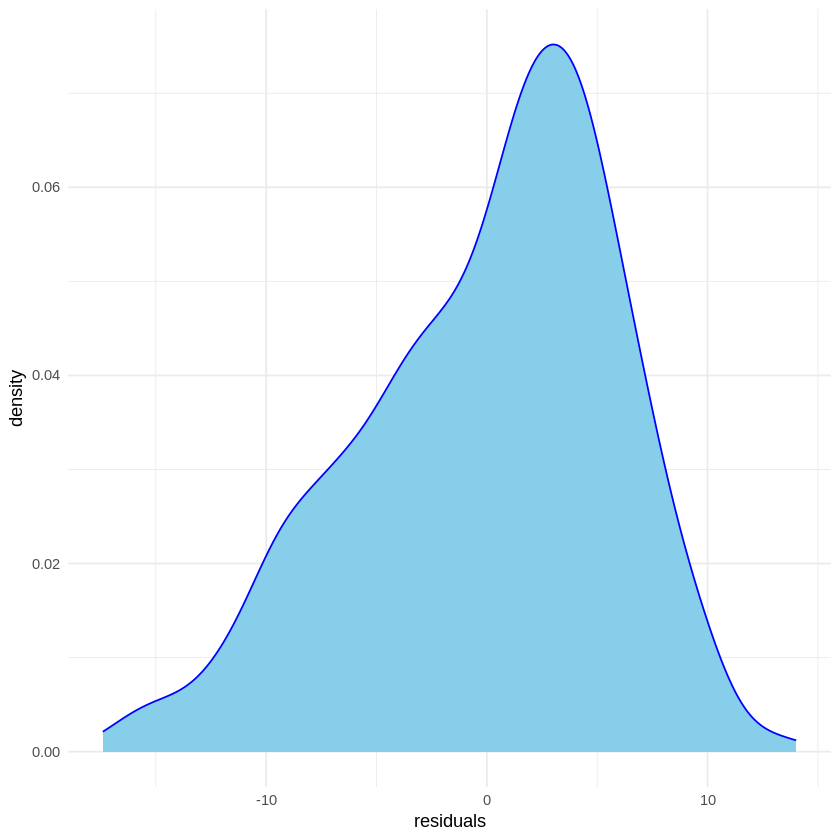

In [70]:
df$residuals = mod1$residuals

ggplot(df, aes(x = residuals)) +
  geom_density(fill = "skyblue", color = "blue") +
  theme_minimal()

And the prediction...

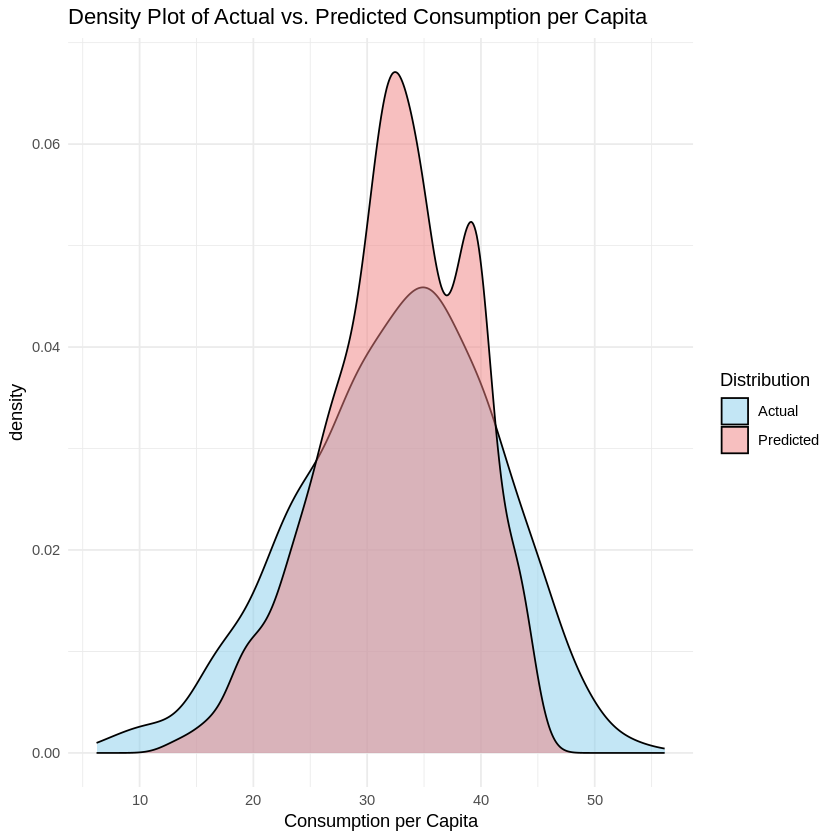

In [71]:
df$predicted <- predict(mod1)

ggplot(df, aes(x = consumption_pc)) +
  geom_density(aes(fill = "Actual"), alpha = 0.5) +
  geom_density(aes(x = predicted, fill = "Predicted"), alpha = 0.5) +
  scale_fill_manual(values = c("Actual" = "skyblue", "Predicted" = "lightcoral")) +
  theme_minimal() +
  labs(title = "Density Plot of Actual vs. Predicted Consumption per Capita",
       x = "Consumption per Capita",
       fill = "Distribution")

Estimating poverty rate. Assume poverty line = 32.

In [72]:
# Actual
cat("Actual poverty rate: ",mean(df$consumption_pc<32),"\n")

# Predicted
cat("Predicted poverty rate: ",mean(df$predicted<32))

Actual poverty rate:  0.444 
Predicted poverty rate:  0.437

Good enough. What if poverty line = 27

In [73]:
# Actual
cat("Actual poverty rate: ",mean(df$consumption_pc<27),"\n")

# Predicted
cat("Predicted poverty rate: ",mean(df$predicted<27))

Actual poverty rate:  0.251 
Predicted poverty rate:  0.181

Uh-oh. Something went wrong. Let's explore.

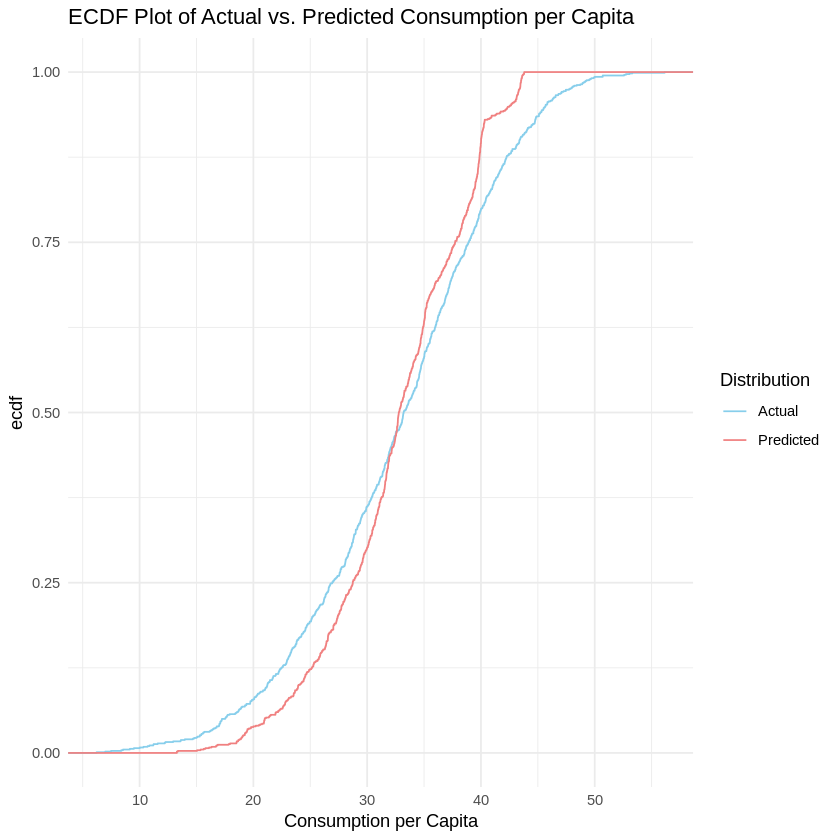

In [74]:
ggplot(df, aes(x = consumption_pc)) +
  stat_ecdf(aes(color = "Actual")) +
  stat_ecdf(aes(x = predicted, color = "Predicted")) +
  scale_color_manual(values = c("Actual" = "skyblue", "Predicted" = "lightcoral")) +
  theme_minimal() +
  labs(title = "ECDF Plot of Actual vs. Predicted Consumption per Capita",
       x = "Consumption per Capita",
       color = "Distribution")

Let's try to get a better hat.

In [75]:
mod2=step(mod1)
summary(mod2)

Start:  AIC=3545.85
consumption_pc ~ age + age_sq + areaurban + electricity + house_ownership + 
    roofmetal + hhsize

                  Df Sum of Sq   RSS    AIC
- hhsize           1      31.8 34151 3544.8
<none>                         34119 3545.8
- age_sq           1     533.1 34652 3559.4
- age              1    1083.5 35202 3575.1
- roofmetal        1    2440.1 36559 3612.9
- house_ownership  1    6245.7 40365 3712.0
- electricity      1   11302.6 45421 3830.0
- areaurban        1   11991.8 46111 3845.0

Step:  AIC=3544.78
consumption_pc ~ age + age_sq + areaurban + electricity + house_ownership + 
    roofmetal

                  Df Sum of Sq   RSS    AIC
<none>                         34151 3544.8
- age_sq           1     530.1 34681 3558.2
- age              1    1077.6 35228 3573.8
- roofmetal        1    2437.4 36588 3611.7
- house_ownership  1    6287.1 40438 3711.8
- electricity      1   11364.9 45516 3830.1
- areaurban        1   11966.8 46117 3843.2



Call:
lm(formula = consumption_pc ~ age + age_sq + areaurban + electricity + 
    house_ownership + roofmetal, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-17.521  -4.042   1.137   4.235  14.119 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      7.0582416  1.4874361   4.745 2.39e-06 ***
age              0.3550098  0.0634225   5.598 2.81e-08 ***
age_sq          -0.0025293  0.0006442  -3.926 9.23e-05 ***
areaurban        7.3313414  0.3930245  18.654  < 2e-16 ***
electricity      8.1200231  0.4466825  18.179  < 2e-16 ***
house_ownership  5.1013422  0.3772984  13.521  < 2e-16 ***
roofmetal        3.5421459  0.4207521   8.419  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.864 on 993 degrees of freedom
Multiple R-squared:  0.5321,	Adjusted R-squared:  0.5292 
F-statistic: 188.2 on 6 and 993 DF,  p-value: < 2.2e-16


In [77]:
df$predicted <- predict(mod2)
# Actual
cat("Actual poverty rate: ",mean(df$consumption_pc<27),"\n")

# Predicted
cat("Predicted poverty rate: ",mean(df$predicted<27))


Actual poverty rate:  0.251 
Predicted poverty rate:  0.186

One more try. Let's lasso it.

In [ ]:
install.packages("glmnet")
library(glmnet)
x <- model.matrix(consumption_pc ~ age+age_sq+areaurban +electricity+house_ownership+roofmetal+hhsize, df)[,-1]
y <- df$consumption_pc
lasso_model <- glmnet(x, y, alpha = 1)
df$predicted_lasso <- predict(lasso_model, newx = x, s = min(lasso_model$lambda)) # Use the minimum lambda

# Actual
cat("Actual poverty rate: ",mean(df$consumption_pc<27),"\n")

# Predicted Lasso
cat("Predicted lasso poverty rate: ",mean(df$predicted_lasso<27))